In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import glob


In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [3]:
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [4]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [6]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [7]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('../data/*__sigpeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


8
10


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
test_peaks.loc[ test_peaks['exp_id'] == 'F1R1', 'assay' ].unique().item()

'FADS1'

In [9]:
data

,F1R1,F1R2,F2R1,F2R2,F3R1,F3R2,FnR1,FnR2,cutsite
Coordinates,,,,,,,,,
chr11:61788524-61788546:-,-0.444506,-0.717688,-0.446532,-0.424917,-0.208681,-0.215305,0.093006,0.597376,61788527
chr11:61788527-61788549:-,-0.585573,-0.444525,0.149400,-0.064382,-0.342371,-0.060320,-0.542184,0.875115,61788530
chr11:61788560-61788582:+,-0.413584,-0.325180,-0.753205,-0.219445,-0.108891,-0.073516,-0.350920,0.512321,61788578
chr11:61788568-61788590:+,-0.803122,-0.093714,-0.185422,0.296454,-0.304052,-0.411980,0.498659,0.098764,61788586
chr11:61788568-61788590:-,-0.680877,-1.208815,-0.347912,-0.037850,-0.265037,-0.103503,1.012557,0.526470,61788571
chr11:61788583-61788605:-,-1.074896,-0.293761,-0.322129,0.029612,0.318053,0.171850,-0.013606,0.606533,61788586
chr11:61788622-61788644:+,0.054382,-0.556209,-0.362758,0.025064,-0.301970,-0.009917,0.422857,0.572311,61788640
chr11:61788630-61788652:+,-0.498486,-0.488097,0.158075,-0.121361,0.040588,0.324861,5.288267,-4.110874,61788648
chr11:61788645-61788667:-,-0.792547,-1.033473,-0.401473,-0.349295,-0.040351,-0.619039,2.656055,1.249719,61788648


In [10]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chr11,61813200,61813600,F1R1,FADS1,1
1,chr11,61814000,61818400,F1R1,FADS1,1
2,chr11,61833300,61835900,F1R1,FADS1,1
3,chr11,61837300,61837500,F1R1,FADS1,1
4,chr11,61840400,61840500,F1R1,FADS1,1
5,chr11,61840900,61841000,F1R1,FADS1,1
6,chr11,61841200,61841400,F1R1,FADS1,1
7,chr11,61841500,61842900,F1R1,FADS1,1
8,chr11,61869000,61871800,F1R1,FADS1,1
9,chr11,61800900,61801000,F1R2,FADS1,2


In [11]:
def plot_hff_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    sub_cuts = cutsite_data.loc[:,plot_ids].dropna(axis=1)
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([data['cutsite'].values, 
                                                       (data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    col_dict = { exp_id: color
                 for exp_id, color 
                 in zip(plot_ids, 
                        plt.rcParams['axes.prop_cycle'] \
                          .by_key()['color'][:len(plot_ids)]
                       )
               }
    
    score_max = sub_cuts.loc[:, plot_ids].dropna(axis=1).max().max()
    score_min = sub_cuts.loc[:, plot_ids].dropna(axis=1).min().min()
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    for i, exp_id in enumerate(col_dict.keys()):
        sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
        peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
        for j, row in sub_sub_peaks.iterrows():
            ax.hlines(y=peak_position, 
                      xmin=row['start'], xmax=row['end'],
                      color=col_dict[exp_id])
        if exp_id in cut_types:
            ax.scatter(sub_cuts['cutsite'],sub_cuts[exp_id],color=col_dict[exp_id],s=8,alpha=0.5)
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=col_dict[color]) for color in plot_ids ]
    ax.legend(custom_lines, plot_ids,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return fig
            

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


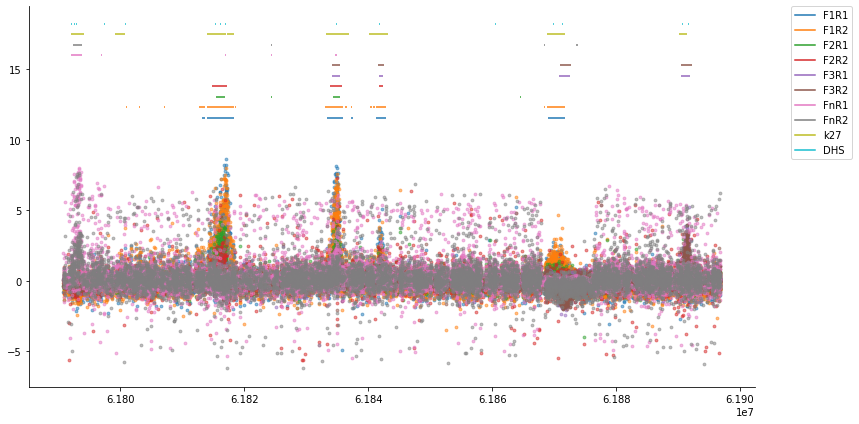

In [12]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


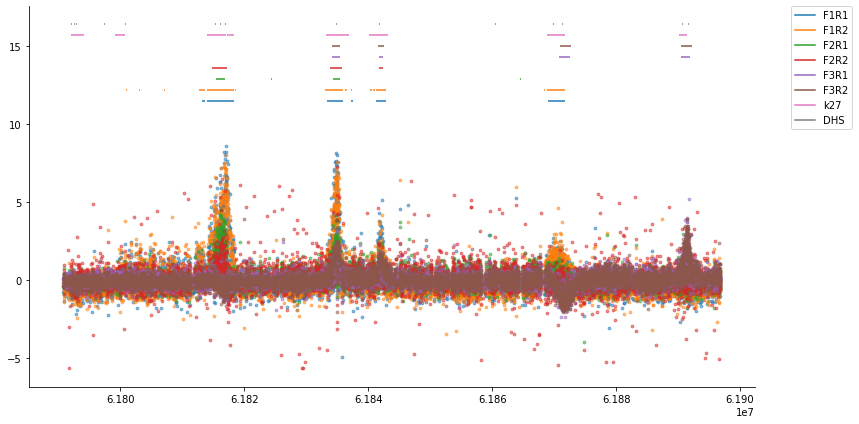

In [13]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


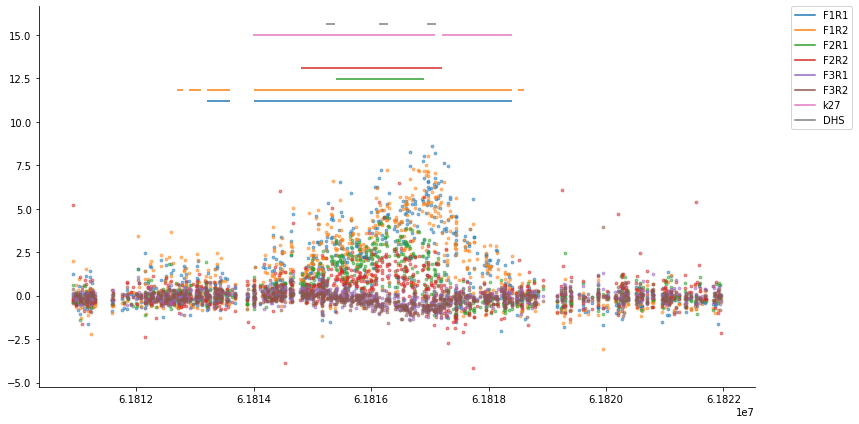

In [14]:
fig_h = plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


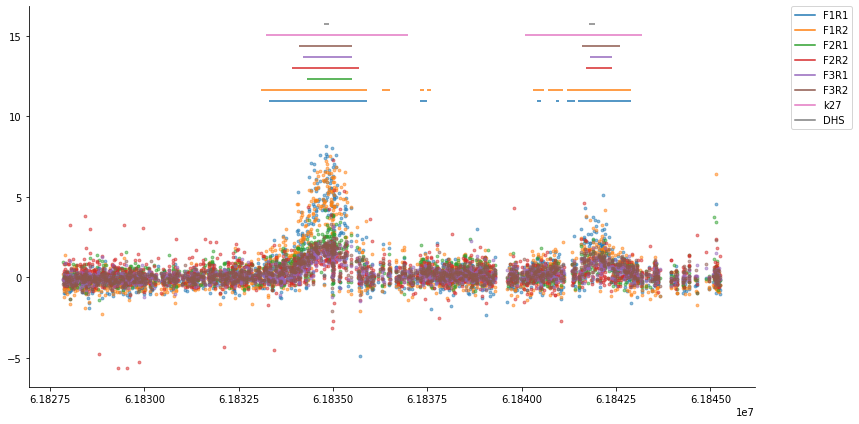

In [15]:
fig_h = plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


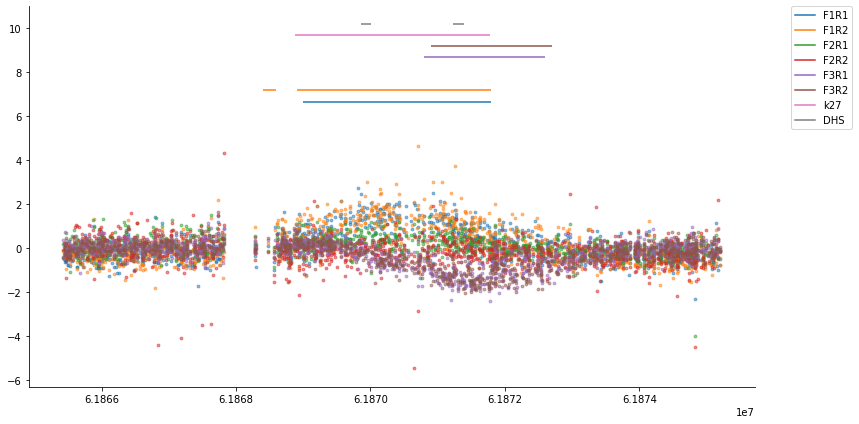

In [16]:
fig_h = plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


In [17]:
def plot_combined_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    sub_cuts = cutsite_data.loc[:,plot_ids].dropna(axis=1)
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([data['cutsite'].values, 
                                                       (data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    score_max = sub_cuts.loc[:, plot_ids].dropna(axis=1).max().max()
    score_min = sub_cuts.loc[:, plot_ids].dropna(axis=1).min().min()
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    avail_data = test_peaks.loc[test_peaks['exp_id'].isin(plot_ids),('exp_id','assay','replicate')].drop_duplicates()
    exp2assay = {}
    assay2exp = {}
    for row in avail_data.iterrows():
        exp2assay[row[1]['exp_id']] = row[1]['assay']
        try:
            assay2exp[row[1]['assay']].append(row[1]['exp_id'])
        except:
            assay2exp[row[1]['assay']] = [row[1]['exp_id']]
    for i, assay in enumerate(avail_data['assay'].unique()):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        for exp_id in assay2exp[assay]:
            sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
            peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
            for j, row in sub_sub_peaks.iterrows():
                ax.hlines(y=peak_position, 
                          xmin=row['start'], xmax=row['end'],
                          color=color)
        have_cuts = [exp_id for exp_id in assay2exp[assay] if exp_id in sub_cuts.columns]
        if len(have_cuts) > 0:
            print(assay)
            ax.scatter(sub_cuts['cutsite'],sub_cuts.loc[:,have_cuts].mean(axis=1),color=color,s=4,alpha=0.5)
            ax.vlines(x=sub_cuts['cutsite'],
                      ymin=sub_cuts.loc[:,have_cuts].min(axis=1),
                      ymax=sub_cuts.loc[:,have_cuts].max(axis=1),
                      color=color,linewidth=0.5)
            print(sum((sub_cuts.loc[:,have_cuts].max(axis=1) - sub_cuts.loc[:,have_cuts].min(axis=1)) < 0.001))
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i]) for i, assay in enumerate(avail_data['assay'].unique()) ]
    ax.legend(custom_lines, avail_data['assay'].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return fig
            

FADS1
1
FADS2
0
FADS3
7
FEN1
2


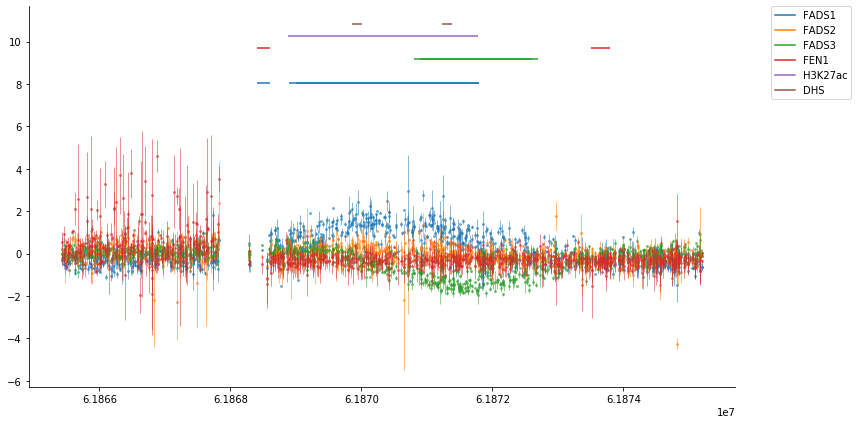

In [18]:
fig_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__all.pdf')

FADS1
1
FADS2
0
FADS3
7


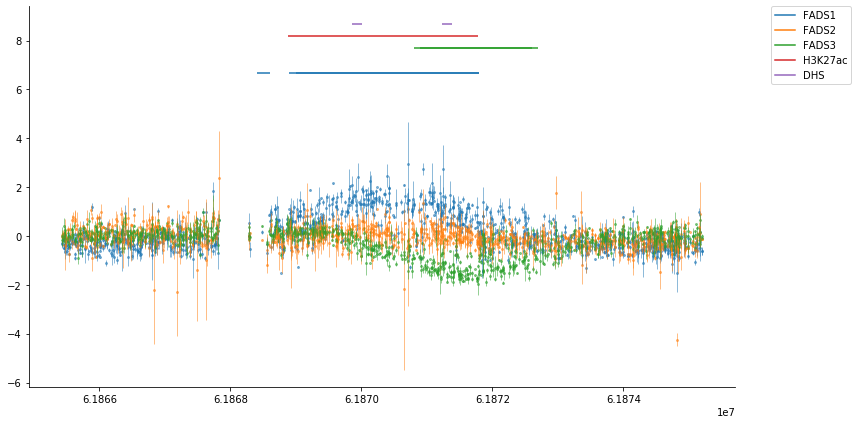

In [19]:
fig_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__noFEN1.pdf')

FADS1
13
FADS2
11
FADS3
30
FEN1
42


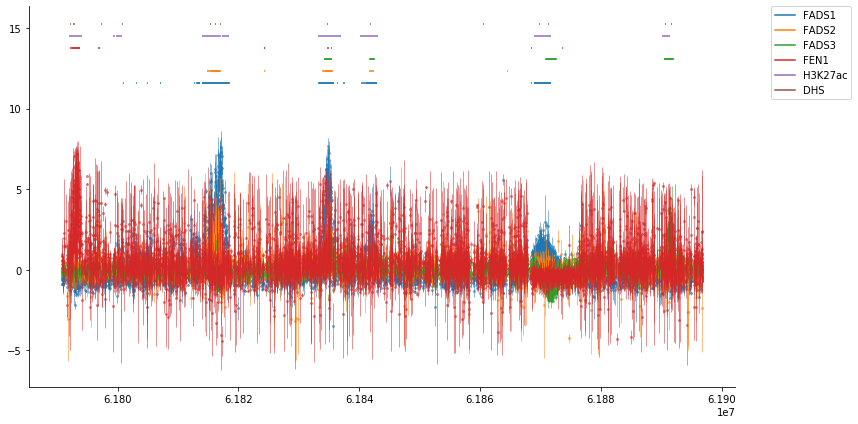

In [20]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


FADS1
13


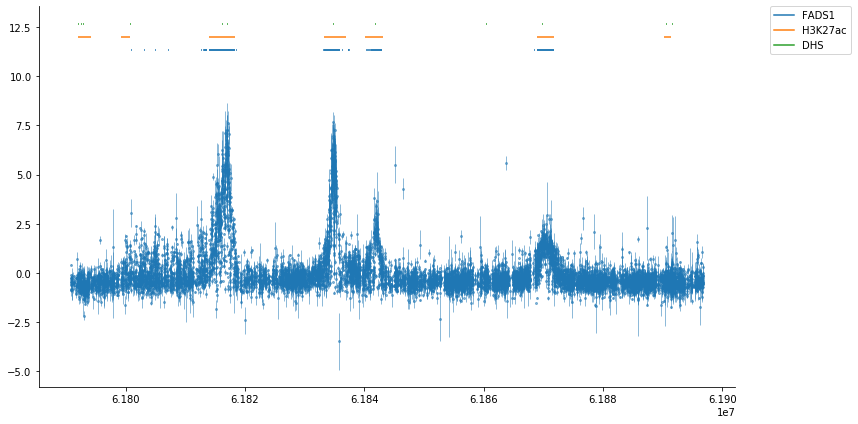

In [21]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])


FADS2
11


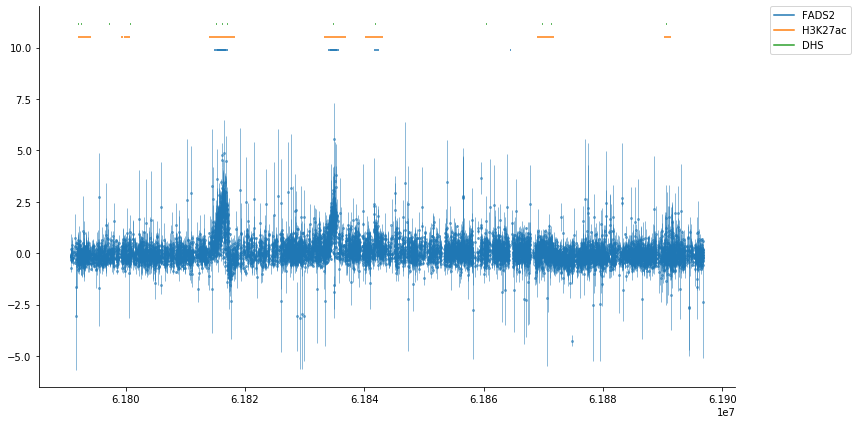

In [22]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F2R1','F2R2','k27','DHS'])


FADS3
30


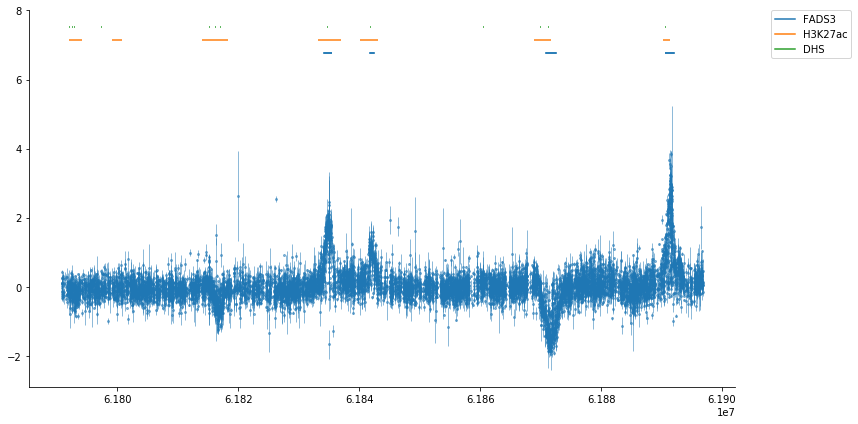

In [23]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F3R1','F3R2','k27','DHS'])


FEN1
42


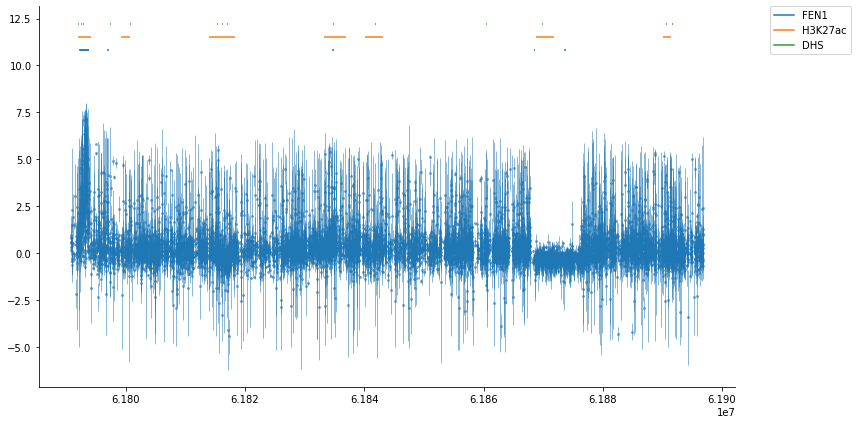

In [24]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FADS1
0
FADS2
1
FADS3
1


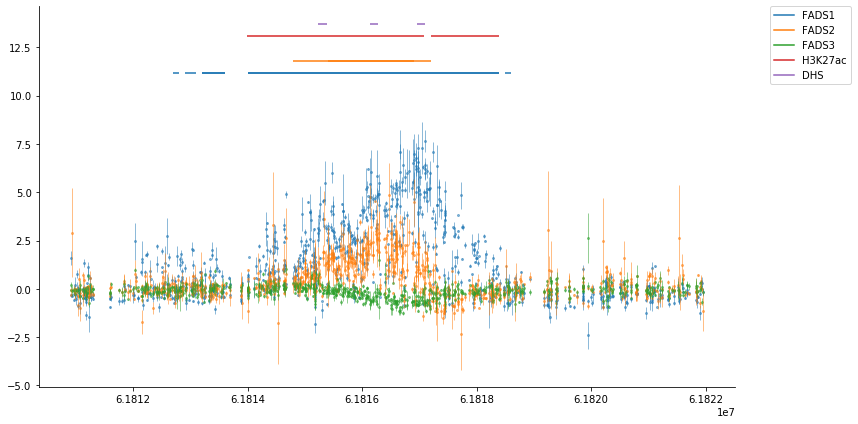

In [25]:
fig_h = plot_combined_cutsites(np.array([[61810908,61822034]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61810908_61822034__noFEN1.pdf')

FADS1
3
FADS2
3
FADS3
9


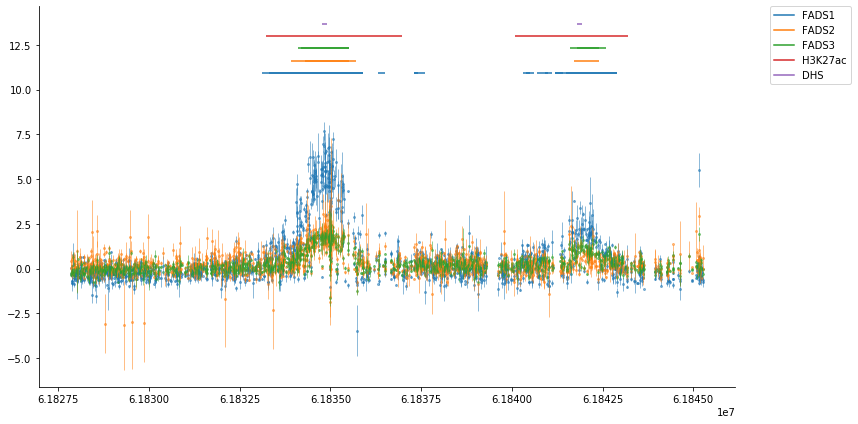

In [26]:
fig_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')